In [8]:
!python3 -m pip install cvxopt

  Using cached https://files.pythonhosted.org/packages/92/fa/10beeb4c6ea4d89f1154c7273a907cab5ce3345f4ac4aa716b21a17502f3/cvxopt-1.2.5-cp37-cp37m-macosx_10_9_x86_64.whl


In [1]:
import numpy as np
import os
import pandas as pd
import cvxopt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.metrics import recall_score, precision_score, confusion_matrix, auc
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import random
import math

In [2]:
base_path = '../../../Dodge/data/defect/'

In [3]:
file_dic = {"ivy": ["ivy-1.1.csv", "ivy-1.4.csv", "ivy-2.0.csv"],
            "lucene": ["lucene-2.0.csv", "lucene-2.2.csv", "lucene-2.4.csv"],
            "poi": ["poi-1.5.csv", "poi-2.0.csv", "poi-2.5.csv", "poi-3.0.csv"],
            "synapse": ["synapse-1.0.csv", "synapse-1.1.csv", "synapse-1.2.csv"],
            "velocity": ["velocity-1.4.csv", "velocity-1.5.csv", "velocity-1.6.csv"],
            "camel": ["camel-1.0.csv", "camel-1.2.csv", "camel-1.4.csv", "camel-1.6.csv"],
            "jedit": ["jedit-3.2.csv", "jedit-4.0.csv", "jedit-4.1.csv", "jedit-4.2.csv", "jedit-4.3.csv"],
            "log4j": ["log4j-1.0.csv", "log4j-1.1.csv", "log4j-1.2.csv"],
            "xalan": ["xalan-2.4.csv", "xalan-2.5.csv", "xalan-2.6.csv", "xalan-2.7.csv"],
            "xerces": ["xerces-1.2.csv", "xerces-1.3.csv", "xerces-1.4.csv"]
           }

In [4]:
def subtotal(x):
    xx = [0]
    for i, t in enumerate(x):
        xx += [xx[-1] + t]
    return xx[1:]


def get_recall(true):
    total_true = float(len([i for i in true if i == 1]))
    hit = 0.0
    recall = []
    for i in range(len(true)):
        if true[i] == 1:
            hit += 1
        recall += [hit / total_true if total_true else 0.0]
    return recall

def get_popt20(data):
    data.sort_values(by=["bug", "loc"], ascending=[0, 1], inplace=True)
    x_sum = float(sum(data['loc']))
    x = data['loc'].apply(lambda t: t / x_sum)
    xx = subtotal(x)

    # get  AUC_optimal
    yy = get_recall(data['bug'].values)
    xxx = [i for i in xx if i <= 0.2]
    yyy = yy[:len(xxx)]
    s_opt = round(auc(xxx, yyy), 3)

    # get AUC_worst
    xx = subtotal(x[::-1])
    yy = get_recall(data['bug'][::-1].values)
    xxx = [i for i in xx if i <= 0.2]
    yyy = yy[:len(xxx)]
    try:
        s_wst = round(auc(xxx, yyy), 3)
    except:
        # print "s_wst forced = 0"
        s_wst = 0
    
    # get AUC_prediction
    data.sort_values(by=["prediction", "loc"], ascending=[0, 1], inplace=True)
    x = data['loc'].apply(lambda t: t / x_sum)
    xx = subtotal(x)
    yy = get_recall(data['bug'].values)
    xxx = [k for k in xx if k <= 0.2]
    yyy = yy[:len(xxx)]
    try:
        s_m = round(auc(xxx, yyy), 3)
    except:
        return 0
    
    Popt = (s_m - s_wst) / (s_opt - s_wst)
    return round(Popt,3)

In [5]:
# from https://pythonprogramming.net/soft-margin-kernel-cvxopt-svm-machine-learning-tutorial/
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(p=3):
    def kernel(x, y, p=p):
        return (1 + np.dot(x, y)) ** p
    
    return kernel

def gaussian_kernel(sigma=5.0):
    def kernel(x, y, sigma=sigma):
        return np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))
    
    return kernel

In [6]:
# from https://stackoverflow.com/questions/30564015/how-to-generate-random-points-in-a-circular-distribution
def fuzz_data(X, y, radii=(0., 1.5, .5)):
    idx = np.where(y == 1)[0]
    frac = len(idx) * 1. / len(y)
    print('debug: weight =', 1./frac)
    
    fuzzed_x = []
    fuzzed_y = []
    
    for row in X[idx]:
        for i, r in enumerate(np.arange(*radii)):
            for j in range(int((1./frac) / pow(2., i))):
                fuzzed_x.append([val - r for val in row])
                fuzzed_x.append([val + r for val in row])
                fuzzed_y.append(1)
                fuzzed_y.append(1)
    
    return np.concatenate((X, np.array(fuzzed_x)), axis=0), np.concatenate((y, np.array(fuzzed_y)))

In [7]:
def solve_dual_problem(X, y, k=.1, kernel=linear_kernel, C=1.):
    m, n = X.shape
    
    idx = np.where(y == -1)[0]
    q = -np.ones((m, 1))
    q[idx] = -k
    q = cvxopt_matrix(q)
    
    y = np.array(y).reshape(1, -1) * 1.
        
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            K[i,j] = kernel(X[i], X[j])

    P = cvxopt.matrix(np.outer(y,y) * K)
    h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))

    cvxopt_solvers.options['show_progress'] = False
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    lambd = np.array(sol['x'])
    y=y.T
    w = ((y * lambd).T @ X).T
    
    ind = np.where(y == -1)[0]
    idx = np.where(y == 1)[0]
    p1 = -k - X[ind] @ w

    ind = np.where(y == 1)[0]
    p2 = 1. - X[idx] @ w

    b = (np.max(p1) + np.min(p2)) / 2
    
    return w, b

In [8]:
def run_on_dataset(filename, metric='recall', draw_roc=False, kernel=linear_kernel, k=.5):
    paths = [os.path.join(base_path, file_name) for file_name in file_dic[filename]]
    train_df = pd.concat([pd.read_csv(path) for path in paths[:-1]], ignore_index=True)
    test_df = pd.read_csv(paths[-1])
    
    train_df, test_df = train_df.iloc[:, 3:], test_df.iloc[:, 3:]
    train_size = train_df["bug"].count()
    df = pd.concat([train_df, test_df], ignore_index=True)
    df['bug'] = df['bug'].apply(lambda x: -1 if x == 0 else 1)
    
    train_data = df.iloc[:train_size, :]
    test_data = df.iloc[train_size:, :]
    
    X_train = train_data[train_data.columns[:-2]]
    y_train = train_data['bug']
    
    X_train, y_train = np.array(get_inliers(X_train, y_train))
    
    X_test = test_data[test_data.columns[:-2]]
    y_test = test_data['bug']
    
    w, b = solve_dual_problem(np.array(X_train), np.array(y_train).reshape(-1,1), k=k, kernel=kernel)
    preds = ((np.array(X_test) @ w + b) > k).astype('int').squeeze()
    preds[preds == 0] = -1
    
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print('tn, fp, fn, tp =', tn, fp, fn, tp)
    fpr = fp * 1.0 / (tn + fp) if (tn + fp) != 0 else 0
    rec = 1.0 * tp / (tp + fn) if (tp + fn) != 0 else 0
    
    test_data.loc[:,"prediction"] = preds
    
    print('Biased SVM results:')
    print('Recall =', recall_score(y_test, preds))
    print('Precision =', precision_score(y_test, preds))
    print('False alarm =', fpr)
    print('d2h =', np.sqrt(fpr ** 2 + (1 - rec) ** 2) / np.sqrt(2))
    print('popt20 =', get_popt20(test_data))

In [9]:
def get_dodge_pareto(filename):
    with open(f'./dodge_results/{filename}.txt', 'r') as f:
        lines = f.readlines()
    
    rec = [float(line.split(', ')[5]) for line in lines]
    pf = [float(line.split(', ')[7]) for line in lines]
    return pf, rec

In [10]:
def get_inliers(X, y):
    n_neighbors = int(np.sqrt(len(X)))
    detector = LocalOutlierFactor(n_neighbors=n_neighbors, metric='euclidean')
    results = detector.fit_predict(X)
    indices = np.where(results == 1)[0]
    
    return np.array(X)[indices], np.array(y)[indices]

In [11]:
def tune(filename, start=.1, end=.9, n_iter=10, plot=True, C=1.):
    if plot:
        points_x = []
        points_y = []
    
    paths = [os.path.join(base_path, file_name) for file_name in file_dic[filename]]
    train_df = pd.concat([pd.read_csv(path) for path in paths[:-1]], ignore_index=True)
    test_df = pd.read_csv(paths[-1])
    
    train_df, test_df = train_df.iloc[:, 3:], test_df.iloc[:, 3:]
    train_size = train_df["bug"].count()
    df = pd.concat([train_df, test_df], ignore_index=True)
    df['bug'] = df['bug'].apply(lambda x: -1 if x == 0 else 1)
    
    train_data = df.iloc[:train_size, :]
    test_data = df.iloc[train_size:, :]
    
    X_train = np.array(train_data[train_data.columns[:-2]])
    y_train = np.array(train_data['bug'])
    X_test = np.array(test_data[test_data.columns[:-2]])
    y_test = test_data['bug']
        
    scaler = StandardScaler()
    scaler.fit_transform(X_train)
    scaler.transform(X_test)
    X_train_fuzzed, y_train_fuzzed = fuzz_data(X_train, y_train, radii=(0., .1, .01))
    
    old_tn, old_fp = 0., -1.
    low_tn = 1e5
    high_fp = -1.
    low = start
    high = end
    low_k, high_k = 0., 0.
    for i in range(n_iter):
        k = (low + high) / 2
        w, b = solve_dual_problem(X_train_fuzzed, y_train_fuzzed.reshape(-1,1), k=k, C=C)
        preds = ((X_test @ w + b) > k).astype('int').squeeze()
        preds[preds == 0] = -1

        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        fpr = fp * 1.0 / (tn + fp) if (tn + fp) != 0 else 0
        rec = 1.0 * tp / (tp + fn) if (tp + fn) != 0 else 0
        print('it', str(i+1) + ':', 'k =', k, '|', 'pf =', fpr, '|', 'rec =', rec, '|', 'tn =', tn, '|', 'fp =', fp)
        
        if tn != old_tn and fp != old_fp:
            if tn < old_tn:
                low = k
                low_tn = tn
                
                if fp > high_fp:
                    high_fp = fp
                    high_k = k
            if tn > old_tn:
                high = k
                
                if tn < low_tn:
                    low_tn = tn
                    low_k = k
        else:
            if tn > low_tn:
                high = k
                low_k = low
            if fp < high_fp:
                high_k = k
                      
        old_tn = tn
        old_fp = fp
        
        if plot:
            points_x.append(fpr)
            points_y.append(rec)
    
    if plot:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111)

        p, r = get_dodge_pareto(filename)
        ax.scatter(points_x, points_y, c='red', alpha=0.4, marker='s', label='B-SVM')
        ax.scatter(p, r, c='blue', alpha=0.25, marker='o', label='DODGE')
        ax.set_xlabel('pf')
        ax.set_ylabel('recall')
        ax.set_title(filename)
        ax.legend()

In [ ]:
tune('ivy', plot=True, n_iter=13, C=1.)

debug: weight = 4.455696202531645
it 1: k = 0.5 | pf = 0.46153846153846156 | rec = 0.65 | tn = 168 | fp = 144
it 2: k = 0.3 | pf = 0.8076923076923077 | rec = 0.85 | tn = 60 | fp = 252
it 3: k = 0.4 | pf = 0.6698717948717948 | rec = 0.775 | tn = 103 | fp = 209


debug: weight = 4.455696202531645
it 1: k = 0.5 | pf = 0.46153846153846156 | rec = 0.65 | tn = 168 | fp = 144
it 2: k = 0.3 | pf = 0.8076923076923077 | rec = 0.85 | tn = 60 | fp = 252
it 3: k = 0.4 | pf = 0.6698717948717948 | rec = 0.775 | tn = 103 | fp = 209
it 4: k = 0.35 | pf = 0.7596153846153846 | rec = 0.825 | tn = 75 | fp = 237
it 5: k = 0.375 | pf = 0.7115384615384616 | rec = 0.825 | tn = 90 | fp = 222
it 6: k = 0.3625 | pf = 0.7403846153846154 | rec = 0.825 | tn = 81 | fp = 231
it 7: k = 0.36875 | pf = 0.7243589743589743 | rec = 0.825 | tn = 86 | fp = 226
it 8: k = 0.365625 | pf = 0.7339743589743589 | rec = 0.825 | tn = 83 | fp = 229
it 9: k = 0.3671875 | pf = 0.7243589743589743 | rec = 0.825 | tn = 86 | fp = 226
it 10: k = 0.36640625 | pf = 0.7307692307692307 | rec = 0.825 | tn = 84 | fp = 228
it 11: k = 0.366796875 | pf = 0.7275641025641025 | rec = 0.825 | tn = 85 | fp = 227
it 12: k = 0.3666015625 | pf = 0.7275641025641025 | rec = 0.825 | tn = 85 | fp = 227
it 13: k = 0.3665

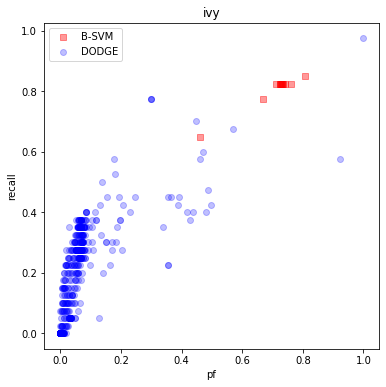

In [13]:
tune('ivy', n_iter=13, C=10.)

debug: weight = 4.455696202531645
it 1: k = 0.5 | pf = 0.46153846153846156 | rec = 0.65 | tn = 168 | fp = 144
it 2: k = 0.3 | pf = 0.8076923076923077 | rec = 0.85 | tn = 60 | fp = 252
it 3: k = 0.4 | pf = 0.6698717948717948 | rec = 0.775 | tn = 103 | fp = 209
it 4: k = 0.35 | pf = 0.7596153846153846 | rec = 0.825 | tn = 75 | fp = 237
it 5: k = 0.375 | pf = 0.7115384615384616 | rec = 0.825 | tn = 90 | fp = 222
it 6: k = 0.3625 | pf = 0.7403846153846154 | rec = 0.825 | tn = 81 | fp = 231
it 7: k = 0.36875 | pf = 0.7243589743589743 | rec = 0.825 | tn = 86 | fp = 226
it 8: k = 0.365625 | pf = 0.7339743589743589 | rec = 0.825 | tn = 83 | fp = 229
it 9: k = 0.3671875 | pf = 0.7243589743589743 | rec = 0.825 | tn = 86 | fp = 226
it 10: k = 0.36640625 | pf = 0.7307692307692307 | rec = 0.825 | tn = 84 | fp = 228
it 11: k = 0.366796875 | pf = 0.7243589743589743 | rec = 0.825 | tn = 86 | fp = 226
it 12: k = 0.3666015625 | pf = 0.7275641025641025 | rec = 0.825 | tn = 85 | fp = 227


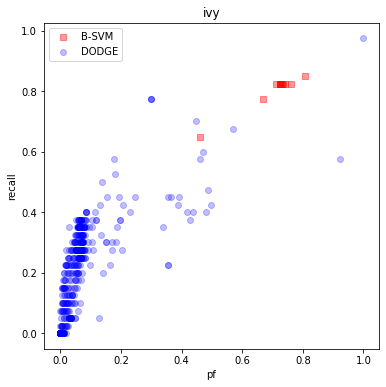

In [14]:
tune('ivy', n_iter=12, C=100.)

In [54]:
run_on_dataset('ivy', k=.35)  # linear kernel

tn, fp, fn, tp = 312 0 40 0
Biased SVM results:
Recall = 0.0
Precision = 0.0
False alarm = 0.0
d2h = 0.7071067811865475
popt20 = 0.277


/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sam

In [146]:
run_on_dataset('ivy', kernel=linear_kernel, k=.5)

tn, fp, fn, tp = 0 312 0 40
Biased SVM results:
Recall = 1.0
Precision = 0.11363636363636363
False alarm = 1.0
d2h = 0.7071067811865475
popt20 = 0.277


/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

In [160]:
run_on_dataset('lucene', kernel=linear_kernel, k=.800000001)

tn, fp, fn, tp = 137 0 197 6
Biased SVM results:
Recall = 0.029556650246305417
Precision = 1.0
False alarm = 0.0
d2h = 0.686207073368226
popt20 = 0.019


/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


debug: weight = 1.8808510638297873
it 1: k = 0.5 | pf = 0.0 | rec = 0.0 | tn = 137 | fp = 0
it 2: k = 0.3 | pf = 1.0 | rec = 1.0 | tn = 0 | fp = 137
it 3: k = 0.4 | pf = 0.0 | rec = 0.0 | tn = 137 | fp = 0
it 4: k = 0.35 | pf = 0.0 | rec = 0.0049261083743842365 | tn = 137 | fp = 0
it 5: k = 0.32499999999999996 | pf = 1.0 | rec = 1.0 | tn = 0 | fp = 137
it 6: k = 0.33749999999999997 | pf = 0.0 | rec = 0.019704433497536946 | tn = 137 | fp = 0
it 7: k = 0.33124999999999993 | pf = 0.7299270072992701 | rec = 0.7980295566502463 | tn = 37 | fp = 100
it 8: k = 0.334375 | pf = 0.0 | rec = 0.024630541871921183 | tn = 137 | fp = 0
it 9: k = 0.33281249999999996 | pf = 0.0 | rec = 0.024630541871921183 | tn = 137 | fp = 0
it 10: k = 0.33203124999999994 | pf = 0.0 | rec = 0.04433497536945813 | tn = 137 | fp = 0
it 11: k = 0.3316406249999999 | pf = 0.0 | rec = 0.04926108374384237 | tn = 137 | fp = 0
it 12: k = 0.3314453124999999 | pf = 0.0 | rec = 0.029556650246305417 | tn = 137 | fp = 0


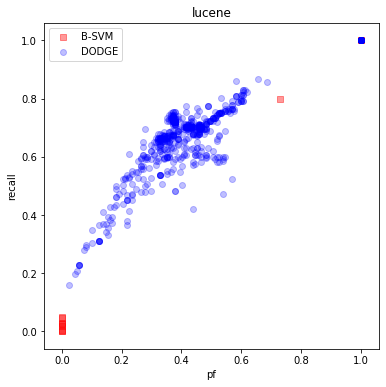

In [18]:
tune('lucene', n_iter=12, C=1e5)

In [66]:
run_on_dataset('lucene', kernel=polynomial_kernel(2.), k=.56)

tn, fp, fn, tp = 0 137 2 201
Biased SVM results:
Recall = 0.9901477832512315
Precision = 0.5946745562130178
False alarm = 1.0
d2h = 0.7071410984290422
popt20 = 0.802


/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [200]:
run_on_dataset('camel')

tn, fp, fn, tp = 0 777 0 188
Biased SVM results:
Recall = 1.0
Precision = 0.19481865284974093
False alarm = 1.0
d2h = 0.7071067811865475
popt20 = 0.536


/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


debug: weight = 4.863636363636363
it 1: k = 0.5 | pf = 0.0 | rec = 0.0 | tn = 777 | fp = 0
it 2: k = 0.3 | pf = 1.0 | rec = 1.0 | tn = 0 | fp = 777
it 3: k = 0.4 | pf = 0.0 | rec = 0.0 | tn = 777 | fp = 0
it 4: k = 0.35 | pf = 0.0 | rec = 0.0 | tn = 777 | fp = 0
it 5: k = 0.32499999999999996 | pf = 1.0 | rec = 1.0 | tn = 0 | fp = 777
it 6: k = 0.33749999999999997 | pf = 0.0 | rec = 0.0 | tn = 777 | fp = 0
it 7: k = 0.33124999999999993 | pf = 1.0 | rec = 1.0 | tn = 0 | fp = 777
it 8: k = 0.334375 | pf = 0.0 | rec = 0.0 | tn = 777 | fp = 0
it 9: k = 0.33281249999999996 | pf = 1.0 | rec = 1.0 | tn = 0 | fp = 777
it 10: k = 0.33359374999999997 | pf = 0.0 | rec = 0.0 | tn = 777 | fp = 0
it 11: k = 0.33320312499999993 | pf = 1.0 | rec = 1.0 | tn = 0 | fp = 777
it 12: k = 0.3333984375 | pf = 0.0 | rec = 0.0 | tn = 777 | fp = 0


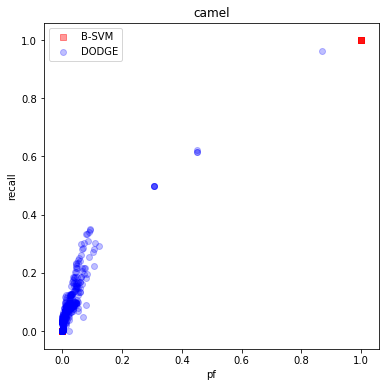

In [23]:
tune('camel', n_iter=12, C=1., end=.9, start=.1)

In [201]:
run_on_dataset('log4j')

tn, fp, fn, tp = 0 16 0 189
Biased SVM results:
Recall = 1.0
Precision = 0.9219512195121952
False alarm = 1.0
d2h = 0.7071067811865475
popt20 = 0.989


/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


debug: weight = 3.4366197183098595
it 1: k = 0.5 | pf = 0.125 | rec = 0.3386243386243386 | tn = 14 | fp = 2
it 2: k = 0.3 | pf = 0.25 | rec = 0.5026455026455027 | tn = 12 | fp = 4
it 3: k = 0.4 | pf = 0.1875 | rec = 0.42857142857142855 | tn = 13 | fp = 3
it 4: k = 0.35 | pf = 0.25 | rec = 0.4603174603174603 | tn = 12 | fp = 4
it 5: k = 0.375 | pf = 0.1875 | rec = 0.43386243386243384 | tn = 13 | fp = 3
it 6: k = 0.3625 | pf = 0.25 | rec = 0.43915343915343913 | tn = 12 | fp = 4
it 7: k = 0.36875 | pf = 0.25 | rec = 0.43915343915343913 | tn = 12 | fp = 4
it 8: k = 0.36875 | pf = 0.25 | rec = 0.43915343915343913 | tn = 12 | fp = 4
it 9: k = 0.36875 | pf = 0.25 | rec = 0.43915343915343913 | tn = 12 | fp = 4
it 10: k = 0.36875 | pf = 0.25 | rec = 0.43915343915343913 | tn = 12 | fp = 4
it 11: k = 0.36875 | pf = 0.25 | rec = 0.43915343915343913 | tn = 12 | fp = 4
it 12: k = 0.36875 | pf = 0.25 | rec = 0.43915343915343913 | tn = 12 | fp = 4
it 13: k = 0.36875 | pf = 0.25 | rec = 0.4391534391534

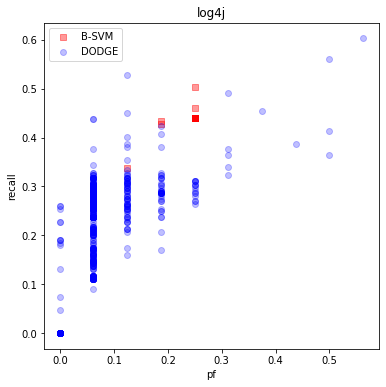

In [29]:
tune('log4j', n_iter=13, C=.4)

debug: weight = 1.8808510638297873
it 1: k = 0.5 | pf = 0.0 | rec = 0.0 | tn = 137 | fp = 0
it 2: k = 0.3 | pf = 1.0 | rec = 1.0 | tn = 0 | fp = 137
it 3: k = 0.4 | pf = 0.0 | rec = 0.0 | tn = 137 | fp = 0
it 4: k = 0.35 | pf = 0.0 | rec = 0.0 | tn = 137 | fp = 0
it 5: k = 0.32499999999999996 | pf = 1.0 | rec = 1.0 | tn = 0 | fp = 137
it 6: k = 0.33749999999999997 | pf = 0.0 | rec = 0.0 | tn = 137 | fp = 0
it 7: k = 0.33124999999999993 | pf = 1.0 | rec = 1.0 | tn = 0 | fp = 137
it 8: k = 0.334375 | pf = 0.0 | rec = 0.0 | tn = 137 | fp = 0
it 9: k = 0.33281249999999996 | pf = 1.0 | rec = 1.0 | tn = 0 | fp = 137
it 10: k = 0.33359374999999997 | pf = 0.0 | rec = 0.0 | tn = 137 | fp = 0
it 11: k = 0.33320312499999993 | pf = 1.0 | rec = 1.0 | tn = 0 | fp = 137
it 12: k = 0.3333984375 | pf = 0.0 | rec = 0.0 | tn = 137 | fp = 0
it 13: k = 0.33330078124999996 | pf = 1.0 | rec = 1.0 | tn = 0 | fp = 137
it 14: k = 0.33334960937499997 | pf = 0.0 | rec = 0.0 | tn = 137 | fp = 0
it 15: k = 0.333325

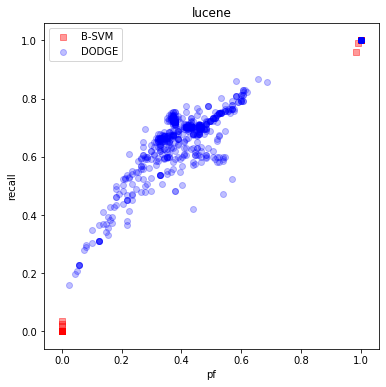

In [33]:
tune('lucene', n_iter=20, C=100.)

In [61]:
run_on_dataset('xalan')

tn, fp, fn, tp = 0 11 0 898
Biased SVM results:
Recall = 1.0
Precision = 0.9878987898789879
False alarm = 1.0
d2h = 0.7071067811865475


In [37]:
tune('xalan', n_iter=15, C=1.)

debug: weight = 2.655286343612335


KeyboardInterrupt: 

In [14]:
run_on_dataset('xerces')

tn, fp, fn, tp = 0 151 0 437
Biased SVM results:
Recall = 1.0
Precision = 0.7431972789115646
False alarm = 1.0
d2h = 0.7071067811865475
popt20 = 0.944


/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

In [35]:
tune('xerces', n_iter=15)

debug: weight = 6.378571428571429


KeyboardInterrupt: 

In [202]:
run_on_dataset('jedit')

tn, fp, fn, tp = 0 481 0 11
Biased SVM results:
Recall = 1.0
Precision = 0.022357723577235773
False alarm = 1.0
d2h = 0.7071067811865475
popt20 = 0.386


/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [36]:
tune('jedit', n_iter=15)

debug: weight = 4.304794520547945


KeyboardInterrupt: 

In [15]:
run_on_dataset('velocity')

tn, fp, fn, tp = 0 151 0 78
Biased SVM results:
Recall = 1.0
Precision = 0.3406113537117904
False alarm = 1.0
d2h = 0.7071067811865475
popt20 = 0.637


/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
run_on_dataset('synapse')

tn, fp, fn, tp = 0 170 0 86
Biased SVM results:
Recall = 1.0
Precision = 0.3359375
False alarm = 1.0
d2h = 0.7071067811865475
popt20 = 0.478


/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
run_on_dataset('poi')

tn, fp, fn, tp = 0 161 0 281
Biased SVM results:
Recall = 1.0
Precision = 0.6357466063348416
False alarm = 1.0
d2h = 0.7071067811865475
popt20 = 0.744


/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
